In [1]:
import tensorflow as tf
import cv2
import sys
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
from Misc.MiscUtils import *
from Misc.DataUtils import *
import numpy as np
import time
import argparse
import shutil
from io import StringIO
import string
from termcolor import colored, cprint
import math as m
from tqdm import tqdm
import csv
from sklearn.preprocessing import StandardScaler
# Don't generate pyc codes
sys.dont_write_bytecode = True

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [18]:
def loadData(folder_name, files_in_dir, labels_in_dir, num_training=5000):

    images_data = []
    labels_data = []

    if(len(files_in_dir) < num_training):
        print("The data has only ", len(files_in_dir) , " images and you are trying to get ",num_training, " images")
        num_training = len(files_in_dir)

    for n in range(num_training):
        image1_name = folder_name + os.sep + "Train_synthetic/PA/" + files_in_dir[n,0]
        image1 = cv2.imread(image1_name)[:,:,0]

        image2_name = folder_name + os.sep + "Train_synthetic/PB/" + files_in_dir[n,0] 
        image2 = cv2.imread(image2_name)[:,:,0]

        if(image1 is None) or (image1 is None):
            print(image1_name, " is empty. Ignoring ...")
            continue

        image1 = np.float32(image1)
        image2 = np.float32(image2)        


        #combile images along depth

        image = np.dstack((image1, image1))
        # #standardize image from 
        # mean = np.mean(image, axis=(1,2), keepdims=True)
        # std = np.std(image, axis=(1,2), keepdims=True)
        # standardized_image = (image - mean) / (std + 0.000001)
         

        labels_data.append(labels_in_dir[n,:])

        images_data.append(image)
        # labels_data.append(label)

    return np.array(images_data), np.array(labels_data)

In [19]:
def createDatasetWithBatches(images_data, labels_data, batch_size, shuffle = True):
    
    N, B = images_data.shape[0], batch_size
    idx = np.arange(N)
    if shuffle:
        np.random.shuffle(idx)
    return iter((images_data[idx[i:i+B]], labels_data[idx[i:i+B]]) for i in range(0, N, B))


In [20]:
def trainModel(ImgPH, LabelPH, dataset, num_epochs, LatestFile, is_training = True):
  
   #add model optimizer loss etc

    with tf.Session() as sess:

        start_epoch = 0
        for epochs in tqdm(range(start_epoch, num_epochs)):
            for b, (x, y) in enumerate(dataset):
                print(b, x.shape, y.shape)
                images_batch = x
                labels_batch = y
                print(b, images_batch.shape, labels_batch.shape)
                             


In [21]:
path = '/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_synthetic/PA/1.jpg'
im = cv2.imread(path)[:,:,0]
im.shape

(128, 128)

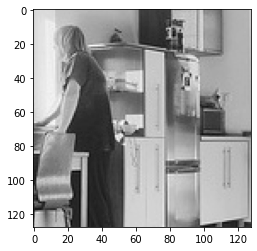

In [22]:
plt.imshow(im,'gray')

In [23]:
BasePath = "/home/sakshi/courses/CMSC733/sakshi_p1/Phase2/Data"
BasePath = "/home/gokul/CMSC733/hgokul_p1/Phase2/Data"
CheckPointPath = "../Checkpoints/supervised/"
files_in_dir, SaveCheckPoint, ImageSize, NumTrainSamples, labels_in_dir = SetupAll(BasePath, CheckPointPath)


In [24]:
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


In [25]:
image_dataset, labels = loadData(BasePath, files_in_dir, labels_in_dir, 10)
print(image_dataset.shape)
print(image_dataset.shape)


(10, 128, 128, 2)
(10, 128, 128, 2)


In [26]:
dataset_train = createDatasetWithBatches(image_dataset, labels, batch_size = 5, shuffle = True)
dataset_val = dataset_train

In [27]:
def ModelInit():
    input_shape = (128, 128, 2)
    hidden_layer_size, num_classes = 1000, 8
    initializer = tf.keras.initializers.VarianceScaling(scale=2.0)
    layers = [
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(hidden_layer_size, activation='relu',
                              kernel_initializer=initializer),
        tf.keras.layers.Dense(num_classes, activation='softmax', 
                              kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model

def OptimizerInit():
    learning_rate = 0.001
    return tf.keras.optimizers.SGD(learning_rate=learning_rate) 

In [35]:
device

'/device:GPU:0'

In [48]:
def TrainModel(device, train_dset, val_dset, model_init_fn, optimizer_init_fn, num_epochs=20, is_training=False): 
    with tf.device(device):
        loss_fn = tf.keras.losses.MeanSquaredError()
        
        model = model_init_fn()
        optimizer = optimizer_init_fn()
        
        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_accuracy = tf.keras.metrics.MeanSquaredError(name='train_accuracy')
    
        val_loss = tf.keras.metrics.Mean(name='val_loss')
        val_accuracy = tf.keras.metrics.MeanSquaredError(name='val_accuracy')
        
        t = 0

        for epoch in range(num_epochs):
            # Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
            train_loss.reset_states()
            train_accuracy.reset_states()

            for x_np, y_np in train_dset:
                print(x_np, y_np)
                with tf.GradientTape() as tape:
                    
                    # Use the model function to build the forward pass.
                    scores = model(x_np, training=is_training)
                    loss = loss_fn(y_np, scores)
      
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    
                    # Update the metrics
                    train_loss.update_state(loss)
                    train_accuracy.update_state(y_np, scores)

                    print_every = 2
                    if t % print_every == 0:
                        val_loss.reset_states()
                        val_accuracy.reset_states()
                        for test_x, test_y in val_dset:
                            # During validation at end of epoch, training set to False
                            prediction = model(test_x, training=False)
                            t_loss = loss_fn(test_y, prediction)

                            val_loss.update_state(t_loss)
                            val_accuracy.update_state(test_y, prediction)
                        
                        template = 'Iteration {}, Epoch {}, Loss: {}, Accuracy: {}, Val Loss: {}, Val Accuracy: {}'
                        print (template.format(t, epoch+1,
                                             train_loss.result(),
                                             train_accuracy.result(),
                                             val_loss.result(),
                                             val_accuracy.result()))
                    t += 1

In [49]:
TrainModel(device, dataset_train, dataset_val, ModelInit, OptimizerInit, num_epochs=20, is_training=True)

In [51]:
dataset_val

<generator object createDatasetWithBatches.<locals>.<genexpr> at 0x7f9787220db0>

In [30]:
ImgPH = None
LabelPH = None
LatestFile = None
trainModel(ImgPH, LabelPH, dataset, 1, LatestFile, is_training = True)

NameError: name 'dataset' is not defined